In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 데이터 불러오기
df = pd.read_csv("xAPI-Edu-Data.csv")
df.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


In [3]:
# 결측치 확인
df.isnull().sum()

gender                      0
NationalITy                 0
PlaceofBirth                0
StageID                     0
GradeID                     0
SectionID                   0
Topic                       0
Semester                    0
Relation                    0
raisedhands                 0
VisITedResources            0
AnnouncementsView           0
Discussion                  0
ParentAnsweringSurvey       0
ParentschoolSatisfaction    0
StudentAbsenceDays          0
Class                       0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   gender                    480 non-null    object
 1   NationalITy               480 non-null    object
 2   PlaceofBirth              480 non-null    object
 3   StageID                   480 non-null    object
 4   GradeID                   480 non-null    object
 5   SectionID                 480 non-null    object
 6   Topic                     480 non-null    object
 7   Semester                  480 non-null    object
 8   Relation                  480 non-null    object
 9   raisedhands               480 non-null    int64 
 10  VisITedResources          480 non-null    int64 
 11  AnnouncementsView         480 non-null    int64 
 12  Discussion                480 non-null    int64 
 13  ParentAnsweringSurvey     480 non-null    object
 14  ParentschoolSatisfaction  

## EDA(학업 환경 정보) - 데이터에 대한 설명

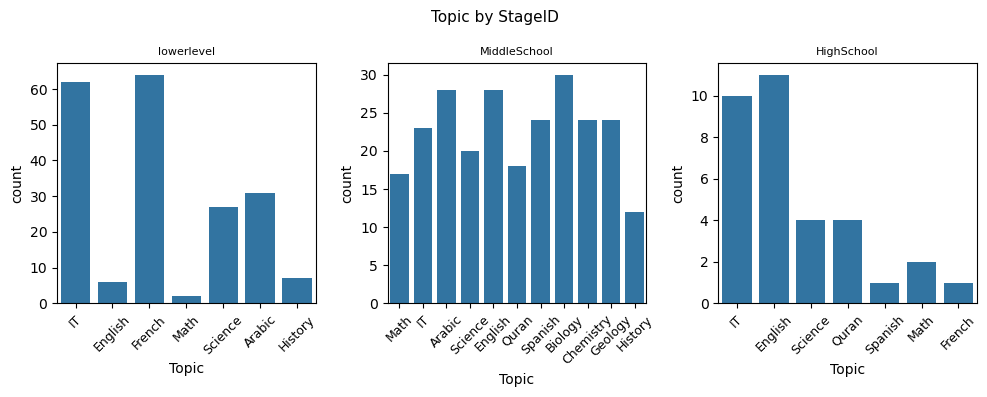

In [6]:
L_stage = df[df.StageID == 'lowerlevel']
M_stage = df[df.StageID == 'MiddleSchool']
H_stage = df[df.StageID == 'HighSchool']

plt.figure(figsize=(10,4))
j = 1

for i in [L_stage, M_stage, H_stage]:
    plt.subplot(1,3, j)
    sns.countplot(x=i['Topic'])
    plt.xticks(rotation=45, fontsize=9)
    plt.title(f'{i.StageID.unique()[0]}', fontsize=8)
    j += 1

plt.suptitle('Topic by StageID', fontsize=11)
plt.tight_layout()
plt.show()

- stageID별 Topic의 개수가 다르다. MiddleSchool은 과목이 다양해서 크게 몇 과목에만 치우치지 않는다.
- French는 MiddleSchool에 없다.
- Arabic은 HighSchool에 없다.
    - 대부분의 학생이 쿠웨이트, 요르단 출신이라 어렸을 때부터 Arabic을 배우고 Quran 과목을 Middle/HighSchool에서 수강하는 것 같다.

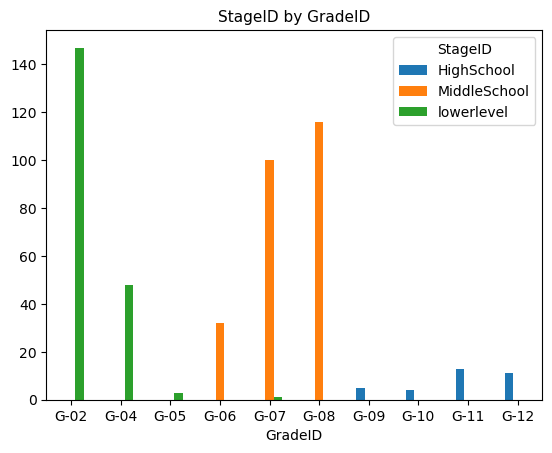

In [8]:
pd.crosstab(columns=df.StageID, index=df.GradeID, values=df.gender, aggfunc='count').plot.bar(rot=0)

plt.title("StageID by GradeID", fontsize=11)
plt.show()

- 같은 GradeID(G-07)가 다른 StageID(MiddleSchool)에도 있다.
- GradeID(G-02)학년 학생이 가장 많다.

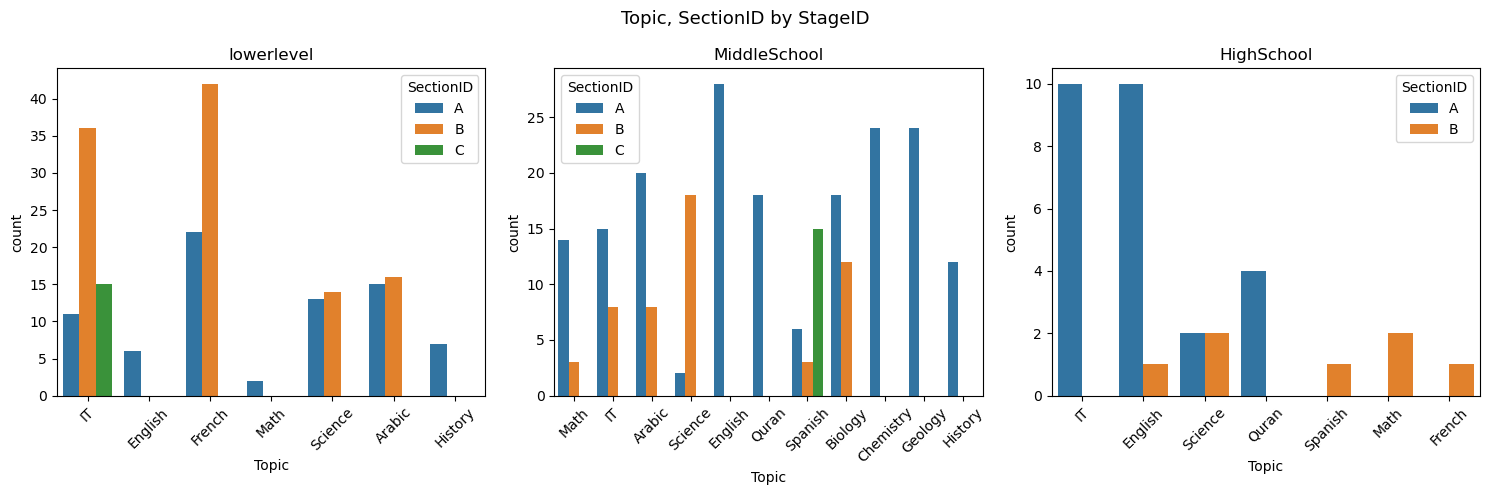

In [10]:
plt.figure(figsize=(15, 5))
j = 1

for i in [L_stage, M_stage, H_stage]:
    plt.subplot(1, 3, j)
    sns.countplot(x=i['Topic'], hue=i['SectionID'])
    plt.xticks(rotation=45)
    plt.title(i.StageID.unique()[0])
    j += 1
    
plt.suptitle('Topic, SectionID by StageID', fontsize=13)
plt.tight_layout()
plt.show()

- section(C)반은 GradeID(G-02, G-08)학년만 있고, Topic(IT와 Spanish)을 수강한다.

요약
- MiddleSchool과 HighSchool은 과목과 교육 과정에서 차별화된 특징을 가질 수 있으며, 각 GradeID별로 교육과정과 수업 선택이 다를 수 있다.
- 특정 학년(GradeID)에서는 특정 과목들이 집중적으로 제공되며, 예를 들어 G-02 학년 학생들이 가장 많고, SectionID(C)반은 특정 과목들만 수강하도록 구성되어 있다.
- 과목의 제공 여부(Arabic, French)는 각 학년과 학교의 교육 방향과 학생 수요에 따라 다르게 나타날 수 있다.

## 예측모델(학업 환경 정보)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [22]:
# 범주형 변수 인코딩
label_encoders = {}
columns = ["StageID", "GradeID", "SectionID", "Semester", "Topic"]
for col in columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [23]:
# 데이터 분리
X = df[columns]
y = df["Class"]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [24]:
# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# 예측 수행
y_pred = model.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.3542


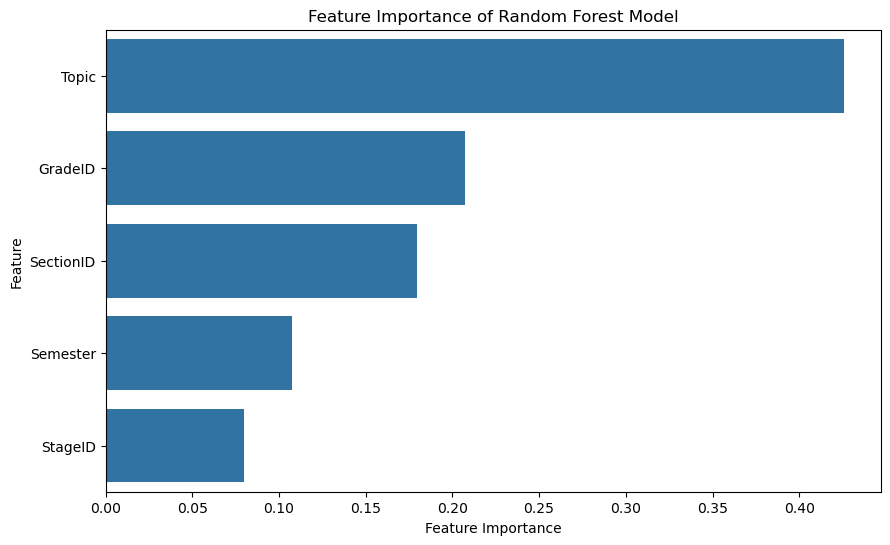

In [29]:
# Feature Importtance 추출
feature_importances = model.feature_importances_
feature_names = X.columns

# 데이터 프레임으로 변환 후 정렬
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# 시각화
plt.figure(figsize=(10,6))
sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance of Random Forest Model")
plt.show()

- StageID, GradeID, SectionID, Topic, Semester는 범주형 데이터이므로 Label Encoding을 수행하였고 랜덤포레스트(Random Forest) 모델을 선택하였다.
- 랜덤포레스트(Random Forest)는 각 특성이 예측에 얼마나 기여했는지 특성 중요도(Feature Importance)를 제공하고 이를 통해 어떤 요소가 학생의 성적 등급(Class)에 영향을 주는지 분석 가능하다.
- 랜덤포레스트(Random Forest)에서 특성 중요도(Feature Importance)를 구하였을 때 Topic, GradeID, SectionID, Semester, StageID 순으로 중요도를 가지는지 보인다.

## 가설 1 : 학년이 높아지면 성적이 오를 것이다.

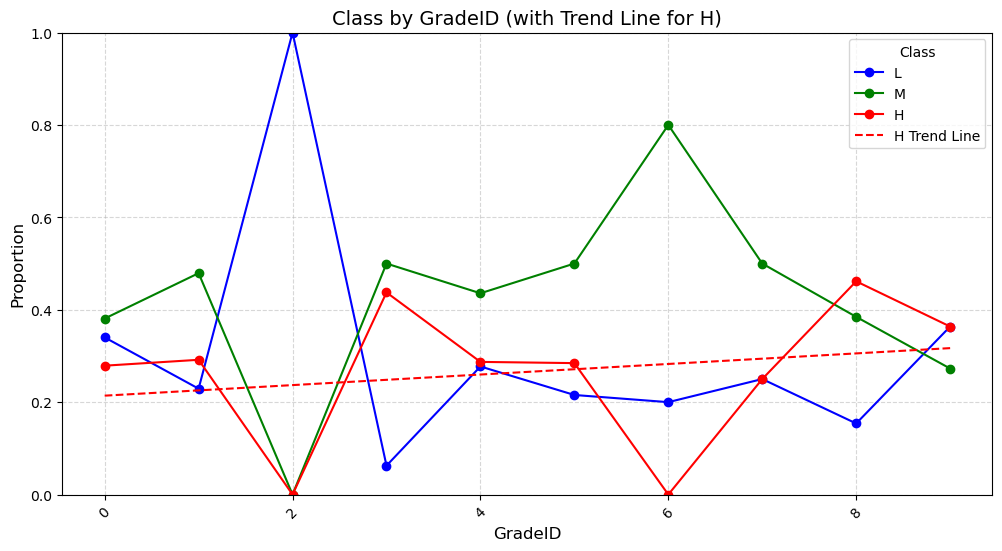

In [33]:
# Class 열을 L → M → H 순서로 정렬
df['Class'] = pd.Categorical(df['Class'], categories=['L', 'M', 'H'], ordered=True)

# 학년별 Class 비율 계산
cross_tab = pd.crosstab(df['GradeID'], df['Class'], normalize='index')

# 학년을 숫자로 변환 (예: 'G-01' → 1, 'G-02' → 2, ...)
cross_tab['Grade_Num'] = range(1, len(cross_tab) + 1)

plt.figure(figsize=(12,6))

# L, M, H 각각의 변화를 선 그래프로 표현
for class_label, color in zip(['L', 'M', 'H'], ['b', 'g', 'r']):  # L:파랑, M:초록, H:빨강
    plt.plot(cross_tab.index, cross_tab[class_label], marker='o', linestyle='-', color=color, label=f"{class_label}")

# H 클래스에 대한 선형 회귀 (추세선)
x = cross_tab['Grade_Num']  # 학년을 숫자로 변환한 값
y = cross_tab['H']  # H 클래스 비율

# 선형 회귀 (1차 다항식) 추세선 계산
coeffs = np.polyfit(x, y, 1)  # 1차 다항식 (ax + b)
trend_line = np.poly1d(coeffs)  # 추세선 함수 생성
plt.plot(cross_tab.index, trend_line(x), "r--", label="H Trend Line")  # 추세선 추가 (빨간색 점선)

# 그래프 설정
plt.title("Class by GradeID (with Trend Line for H)", fontsize=14)
plt.xlabel("GradeID", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 1)  # 비율이므로 0~1 범위 설정
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Class")
plt.show()


- 결론 : 학년이 많아질수록 성적이 High인 학생들이 점점 많아지는 추세를 보이고있다.

## 가설2 : 학기에 따라 수업 참여도 및 성적이 높아질것이다.

In [37]:
melt = pd.melt(df,id_vars='Class',value_vars=['raisedhands','VisITedResources','AnnouncementsView'])

Text(0.5, 1.0, 'High, middle and low level students')

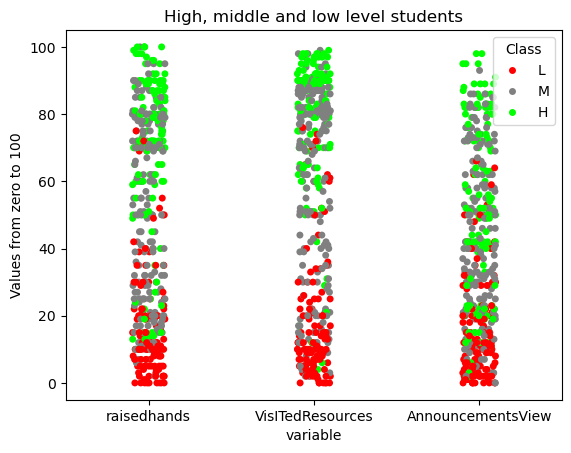

In [39]:
sns.stripplot(x='variable', y='value', hue='Class', data=melt,palette={'H':'lime','M':'grey','L':'red'})
plt.ylabel('Values from zero to 100')
plt.title('High, middle and low level students')

- 성적이 높을수록 손을 든 횟수, 과정 내용을 방문한 횟수, 과목 공지를 확인한 횟수가 높게 분포 되어 있는 것으로 보인다.

<Axes: xlabel='Class', ylabel='Semester'>

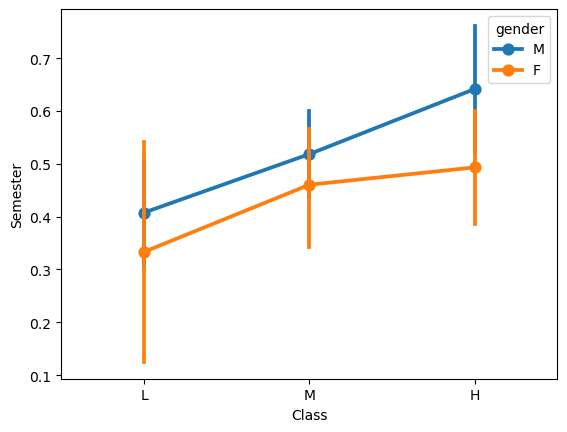

In [42]:
sns.pointplot(x='Class', y='Semester', hue='gender', order=['L','M','H'], data=df)

- 학기에 따라 성적도 높아지는 것을 보인다.

<Axes: xlabel='Semester', ylabel='AnnouncementsView'>

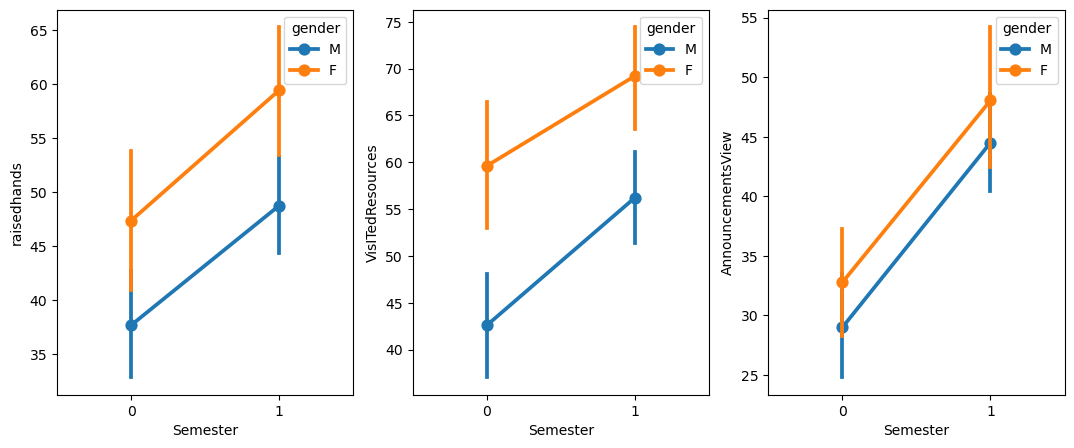

In [45]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3,figsize=(13,5))
sns.pointplot(x='Semester', y='raisedhands', hue='gender', data=df, ax=axis1)
sns.pointplot(x='Semester', y='VisITedResources', hue='gender', data=df, ax=axis2)
sns.pointplot(x='Semester', y='AnnouncementsView', hue='gender', data=df, ax=axis3)

- 학기에 따라 학생의 손을 든 횟수, 과정 내용을 방문한 횟수, 과목 공지를 확인한 횟수가 높아지는 것을 볼수있다.

<Axes: xlabel='Semester', ylabel='AnnouncementsView'>

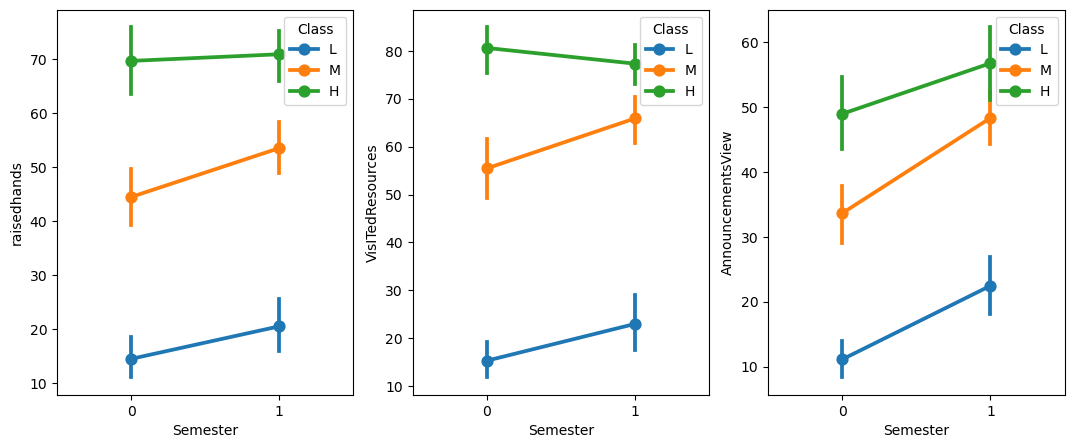

In [48]:
fig, (axis1, axis2, axis3)  = plt.subplots(1, 3,figsize=(13,5))
sns.pointplot(x='Semester', y='raisedhands', hue='Class', data=df, ax=axis1)
sns.pointplot(x='Semester', y='VisITedResources', hue='Class', data=df, ax=axis2)
sns.pointplot(x='Semester', y='AnnouncementsView', hue='Class', data=df, ax=axis3)

- 학기와 학생의 손을 든 횟수, 과정 내용을 방문한 횟수, 과목 공지를 확인한 횟수에 따라 성적도 높아지는 것을 볼 수 있다.

## 새로운 데이터를 통한 가설 보강

In [52]:
df3 = pd.read_csv("student_performance.csv")
df3

,StudentID,Name,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade
0,1,John,Male,85,15,78,1,High,80
1,2,Sarah,Female,90,20,85,2,Medium,87
2,3,Alex,Male,78,10,65,0,Low,68
3,4,Michael,Male,92,25,90,3,High,92
4,5,Emma,Female,88,18,82,2,Medium,85
5,6,Olivia,Female,95,30,88,1,High,90
6,7,Daniel,Male,70,8,60,0,Low,62
7,8,Sophia,Female,85,17,77,1,Medium,78
8,9,James,Male,82,12,70,2,Low,72
9,10,Isabella,Female,91,22,86,3,High,88


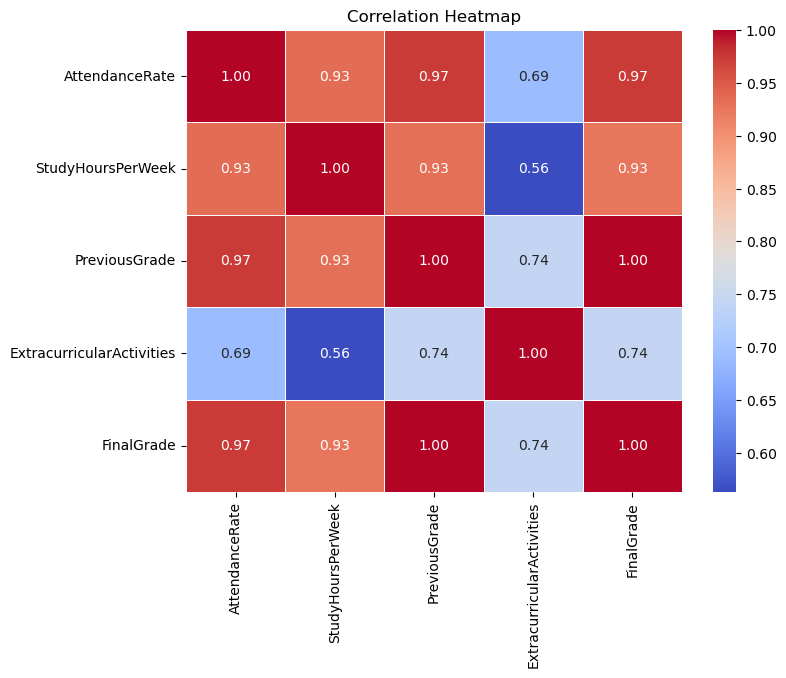

In [54]:
# 상관관계 (히트맵)
df4 = df3[['AttendanceRate', 'StudyHoursPerWeek', 'PreviousGrade', 'ExtracurricularActivities', 'FinalGrade']]
corr_matrix = df4.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

- PreviousGrade은 FinalGrade과 매우 강한 상관 관계를 가지고 있다.

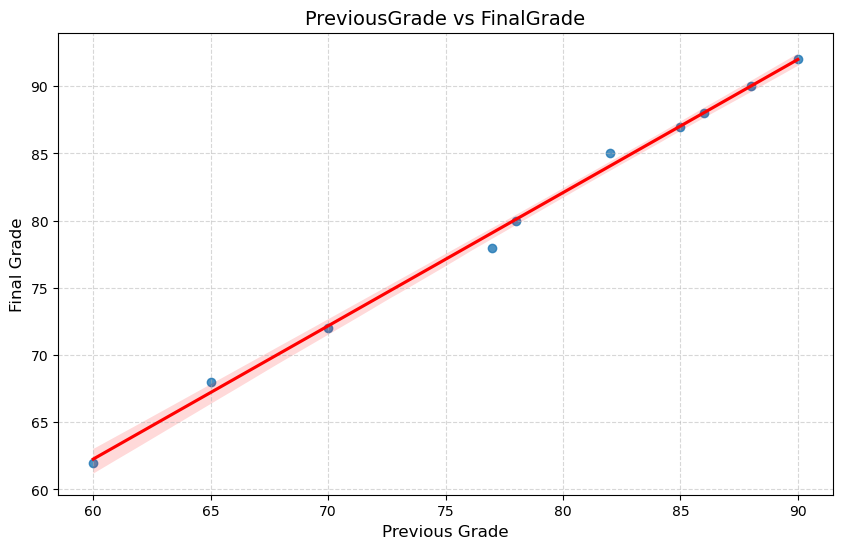

In [57]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df3, x="PreviousGrade", y="FinalGrade", line_kws={'color':'red'})

plt.title("PreviousGrade vs FinalGrade", fontsize=14)
plt.xlabel("Previous Grade", fontsize=12)
plt.ylabel("Final Grade", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

- 산점도의 점들이 위쪽에 몰려있는 점으로 보아 성적이 상승한 학생들이 많은것을 알수있다.